<a href="https://colab.research.google.com/github/yuvalofek/Deep_Learning/blob/master/DeepLearningAssignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**ECE472, Deep Learning – Assignment 1**

Submit by Sept. 9, 10pm

tldr: Perform linear regression of a noisy sinewave
using a set of gaussian basis functions with learned
location and scale parameters. Model parameters are
learned with stochastic gradient descent. Use of
automatic differentiation is required. Hint: note
your limits!

In [ ]:
import numpy as np
import tensorflow as tf
import numpy.random as npr
import matplotlib.pyplot as plt

In [ ]:
### parameters
N =50
sigma_noise = 0.1
M = 2
Nsteps = 300
step_size  = 0.015
seed =5

class noisy_sine:
  def __init__(self, sig, N, seed = None):
    '''
    Generates a sinusoidal sin(2pix), where x in stored in x_rl
    and y in y_rl. Then samples in uniformly with samples x and 
    values y
    '''
    npr.seed(seed)

    self.x_rl = np.linspace(0,1,1000)
    self.y_rl = np.sin(np.pi*2*self.x_rl)

    self.x = npr.uniform(size = (N,1))
    y = np.sin(np.pi*2*self.x) +npr.normal(size = (N,1) )*sigma_noise
    self.y = y.reshape(-1)

class linregmodel:
  def __init__(self, M, seed,
               step_size, initializer = tf.keras.initializers.GlorotNormal):
    '''
    Initialize weights, means, standard of deviation,
    and b vectors according to the xavier normal 
    initializer and return them in dicitonary params. 
    M - number of gaussians to use (and therefore also
        weights, mean, and sds)
    '''
    initializer = initializer(seed)
    W = tf.Variable(initializer(shape=(1,M)), name = 'W')
    mu = tf.Variable(initializer(shape=(1,M)), name = 'mu')
    sig = tf.Variable(initializer(shape=(1,M)), name = 'sig')
    b =tf.Variable(initializer(shape=(1,1)), name = 'b')
    self.params = {'W': W,
            'mu': mu,
            'sig':sig,
            'b':b}
    self.step_size = step_size

  def predict(self, X):
    '''
    Predicts the corresponding y's for the input
    X (N,1) given M gaussian curves with
    parameters from the params dict, and offsett b 
    also from params
    '''
    gaussians = tf.math.exp(-tf.math.square(X-self.params['mu'])/
                            tf.math.square(self.params['sig']))
    y_hat = tf.reduce_sum(
        tf.multiply(gaussians,(self.params['W'])), axis = 1) + self.params['b']
    return y_hat

  def loss(self, x,y):
    '''
    Determines the loss of the predicted value 
    compared to the actual y value. Loss function
    is 0.5(y-y^)**2.
    '''
    y_hat = self.predict(x)
    return  0.5*(y-y_hat)**2

  def step(self, x,y):
    '''
    A single step - predicting values, getting loss,
    & using the gradients of 
    loss to update the parameters
    '''
    with tf.GradientTape(persistent=True) as tape: 
      tape.watch(self.params)
      lss = self.loss(x,y)
    #get gradients
    grads = tape.gradient(lss, self.params)
    #return updated parameters
    self.params = {k:val-grads[k]*self.step_size for k,val in self.params.items()}

  def get_params(self):
    '''
    returns formatted model parameters
    '''
    return (self.params['W'].numpy()[0].reshape(1,-1),
            self.params['b'].numpy()[0][0],
            self.params['mu'].numpy()[0].reshape(1,-1),
            self.params['sig'].numpy()[0].reshape(1,-1)
    )
### Running the Experiment
data = noisy_sine(sigma_noise, N, seed)
x_tf = tf.convert_to_tensor(data.x, dtype=tf.float32)
y_tf = tf.convert_to_tensor(data.y, dtype=tf.float32)

model = linregmodel(M, seed, step_size)
for _ in range(Nsteps):
  for i in range(len(x_tf)):
    params = model.step(tf.gather(x_tf,i),tf.gather(y_tf,i))

x_exp = np.linspace(0,1, 1000)
#formatting output 
W,b,mu,sig = model.get_params()
#predicted curve
y_hat = np.sum(W*np.exp(-(x_exp.reshape(-1,1) - mu)**2/
    (sig)**2),axis =1) + b

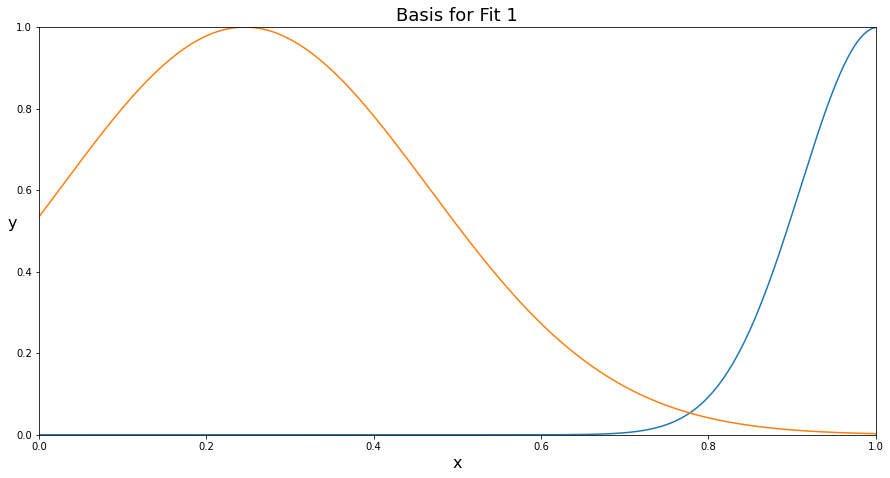

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


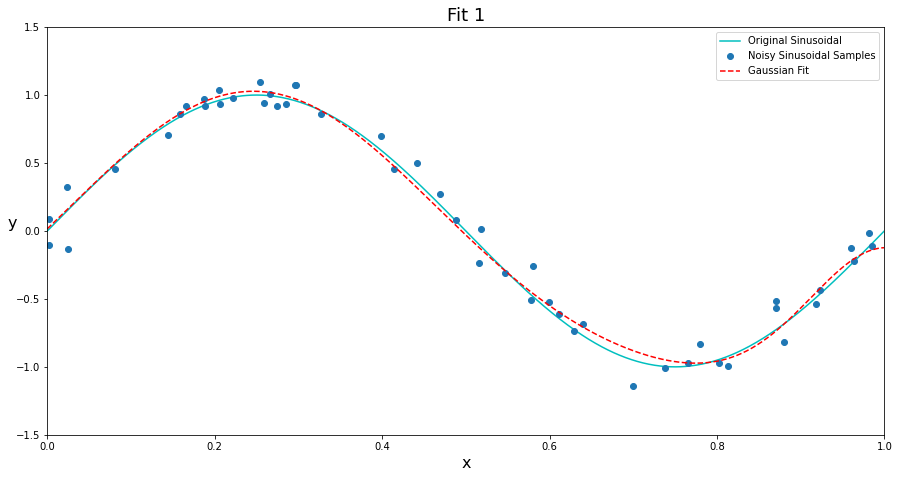

In [ ]:
### Plots
#plotting Basis
plt.figure
plt.figure(figsize=(15,7.5))

for i in range(M):
  plt.plot(x_exp, np.exp(-(x_exp - mu.reshape(-1,1)[i])**2/
                           (sig.reshape(-1,1)[i])**2))
plt.xlabel('x', fontsize=16)
h = plt.ylabel('y', fontsize=16)
h.set_rotation(0)
plt.title('Basis for Fit 1', fontsize=18)

plt.xlim(0,1)
plt.ylim(0,1)
plt.savefig('Basis_of_Fit.eps', format='eps')
plt.show()

#plotting Fit
plt.figure
plt.figure(figsize=(15,7.5))

plt.plot(data.x_rl,data.y_rl,'c') #sine
plt.plot(data.x,data.y,'o') #sampled noisy sine
plt.plot(x_exp, y_hat, 'r--')
plt.legend(['Original Sinusoidal',
            'Noisy Sinusoidal Samples',
            'Gaussian Fit'])
plt.xlabel('x', fontsize=16)
h = plt.ylabel('y', fontsize=16)
h.set_rotation(0)
plt.title('Fit 1', fontsize=18)

plt.xlim(0,1)
plt.ylim(-1.5,1.5)
plt.savefig('Fit.eps', format='eps')
plt.show()